In [2]:
# ============================================================
# File: generate_dataset.py
# Purpose: Generate 2D obstacle avoidance dataset for do-mpc
#           and save summary metadata as CSV
# ============================================================

import numpy as np
import os
import csv

def generate_dataset(save_dir='dataset_obstacle'):
    """
    Generate a dataset of (A, B, obstacle) configurations.
    5 dynamics × 10 obstacle positions = 50 scenarios total.
    Each scenario is saved as a separate .npz file.
    A summary CSV file is also created.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Base dynamics
    A_base = np.array([[-1, -2], [2, -1]])
    B_base = np.array([[0], [1]])

    # Generate small perturbations
    dynamics_list = []
    for i in range(5):
        A_var = A_base + 0.2 * np.random.randn(2, 2)
        B_var = B_base + 0.1 * np.random.randn(2, 1)
        dynamics_list.append((A_var, B_var))

    # Obstacle positions
    obstacle_positions = [
        (3, 5), (5, 9), (3, 3), (-3, 3), (-6, 8),
        (3, -5), (-3, -3), (-3, -8), (3, -3), (-3, -3)
    ]
    radius = 0.7

    metadata = []  # store info for CSV

    for dyn_idx, (A, B) in enumerate(dynamics_list):
        for obs_idx, center in enumerate(obstacle_positions):
            scenario_name = f'scenario_{dyn_idx}_{obs_idx}.npz'
            filepath = os.path.join(save_dir, scenario_name)

            # Save data
            np.savez(filepath, A=A, B=B, obstacle_center=center, radius=radius)

            # Flatten A and B for CSV readability
            A_flat = A.flatten()
            B_flat = B.flatten()

            metadata.append({
                'filename': scenario_name,
                'A11': A_flat[0], 'A12': A_flat[1], 'A21': A_flat[2], 'A22': A_flat[3],
                'B1': B_flat[0], 'B2': B_flat[1],
                'obstacle_center_x': center[0],
                'obstacle_center_y': center[1],
                'radius': radius
            })
            print(f"Saved {scenario_name}")

    # Save summary as CSV
    csv_path = os.path.join(save_dir, 'dataset_summary.csv')
    with open(csv_path, mode='w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=metadata[0].keys())
        writer.writeheader()
        writer.writerows(metadata)

    print(f"\n✅ Dataset generated in '{save_dir}/' with {len(metadata)} scenarios.")
    print(f"📄 Summary CSV saved to '{csv_path}'")
    return metadata


if __name__ == "__main__":
    generate_dataset()


Saved scenario_0_0.npz
Saved scenario_0_1.npz
Saved scenario_0_2.npz
Saved scenario_0_3.npz
Saved scenario_0_4.npz
Saved scenario_0_5.npz
Saved scenario_0_6.npz
Saved scenario_0_7.npz
Saved scenario_0_8.npz
Saved scenario_0_9.npz
Saved scenario_1_0.npz
Saved scenario_1_1.npz
Saved scenario_1_2.npz
Saved scenario_1_3.npz
Saved scenario_1_4.npz
Saved scenario_1_5.npz
Saved scenario_1_6.npz
Saved scenario_1_7.npz
Saved scenario_1_8.npz
Saved scenario_1_9.npz
Saved scenario_2_0.npz
Saved scenario_2_1.npz
Saved scenario_2_2.npz
Saved scenario_2_3.npz
Saved scenario_2_4.npz
Saved scenario_2_5.npz
Saved scenario_2_6.npz
Saved scenario_2_7.npz
Saved scenario_2_8.npz
Saved scenario_2_9.npz
Saved scenario_3_0.npz
Saved scenario_3_1.npz
Saved scenario_3_2.npz
Saved scenario_3_3.npz
Saved scenario_3_4.npz
Saved scenario_3_5.npz
Saved scenario_3_6.npz
Saved scenario_3_7.npz
Saved scenario_3_8.npz
Saved scenario_3_9.npz
Saved scenario_4_0.npz
Saved scenario_4_1.npz
Saved scenario_4_2.npz
Saved scena

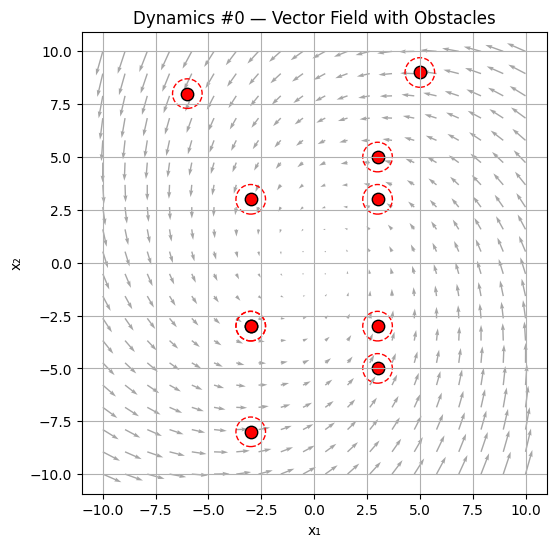

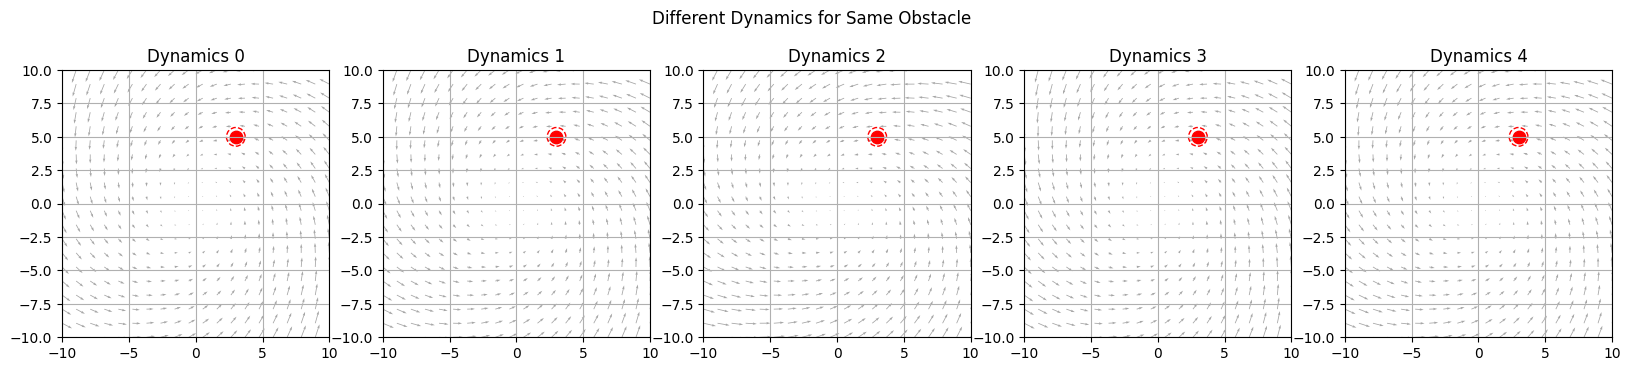

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_dataset_visualization(dataset_dir='dataset_obstacle'):
    # Load metadata summary
    summary_path = os.path.join(dataset_dir, 'dataset_summary.csv')
    data = np.genfromtxt(summary_path, delimiter=',', names=True, dtype=None, encoding='utf-8')

    # ---------------------------------------------------
    # (A) Same dynamics, different obstacles
    # ---------------------------------------------------
    dyn_idx = 0
    subset = [row for row in data if f"scenario_{dyn_idx}_" in row['filename']]

    # Load A, B from one of the scenarios
    sample = np.load(os.path.join(dataset_dir, subset[0]['filename']))
    A, B = sample['A'], sample['B']

    # Define grid for vector field
    x = np.linspace(-10, 10, 20)
    y = np.linspace(-10, 10, 20)
    X, Y = np.meshgrid(x, y)
    U = A[0,0]*X + A[0,1]*Y
    V = A[1,0]*X + A[1,1]*Y

    plt.figure(figsize=(6,6))
    plt.quiver(X, Y, U, V, color='gray', alpha=0.7)
    plt.title(f"Dynamics #{dyn_idx} — Vector Field with Obstacles")

    for row in subset:
        plt.scatter(row['obstacle_center_x'], row['obstacle_center_y'],
                    color='red', s=80, edgecolor='black')
        circle = plt.Circle((row['obstacle_center_x'], row['obstacle_center_y']),
                            row['radius'], color='red', fill=False, linestyle='--')
        plt.gca().add_artist(circle)

    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

    # ---------------------------------------------------
    # (B) Different dynamics, same obstacle
    # ---------------------------------------------------
    obs_idx = 0
    fig, axs = plt.subplots(1, 5, figsize=(20,4))
    for dyn_idx in range(5):
        filename = f"scenario_{dyn_idx}_{obs_idx}.npz"
        sample = np.load(os.path.join(dataset_dir, filename))
        A = sample['A']
        center = sample['obstacle_center']

        # Vector field
        U = A[0,0]*X + A[0,1]*Y
        V = A[1,0]*X + A[1,1]*Y
        axs[dyn_idx].quiver(X, Y, U, V, color='gray', alpha=0.7)
        axs[dyn_idx].scatter(center[0], center[1], color='red', s=80)
        circle = plt.Circle(center, sample['radius'], color='red', fill=False, linestyle='--')
        axs[dyn_idx].add_artist(circle)
        axs[dyn_idx].set_title(f"Dynamics {dyn_idx}")
        axs[dyn_idx].set_xlim([-10,10])
        axs[dyn_idx].set_ylim([-10,10])
        axs[dyn_idx].set_aspect('equal')
        axs[dyn_idx].grid(True)

    plt.suptitle("Different Dynamics for Same Obstacle")
    plt.show()


plot_dataset_visualization(dataset_dir='dataset_obstacle')


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_dataset(dataset_dir='dataset_obstacle'):
    """Load all scenarios and return metadata list."""
    files = sorted([f for f in os.listdir(dataset_dir) if f.endswith('.npz')])
    scenarios = []
    for f in files:
        data = np.load(os.path.join(dataset_dir, f))
        A = data['A']
        B = data['B']
        center = data['obstacle_center']
        radius = data['radius']
        scenarios.append({'filename': f, 'A': A, 'B': B, 'center': center, 'radius': radius})
    return scenarios

def simulate_dynamics(A, B, x0, n_steps=200, dt=0.05, u=0):
    """Simulate linear dynamics x_dot = A x + B u with constant u."""
    xs = [x0.flatten()]
    x = x0.copy()
    for _ in range(n_steps):
        x_dot = A @ x + B * u
        x = x + dt * x_dot
        xs.append(x.flatten())
    return np.array(xs)

def plot_scenario(scenario, x0=np.array([[8], [8]]), dt=0.05, n_steps=200, save_dir='plots'):
    os.makedirs(save_dir, exist_ok=True)

    A, B = scenario['A'], scenario['B']
    center, radius = scenario['center'], scenario['radius']
    filename = scenario['filename']

    # Create grid for vector field
    x1 = np.linspace(-10, 10, 20)
    x2 = np.linspace(-10, 10, 20)
    X1, X2 = np.meshgrid(x1, x2)
    U = A[0, 0]*X1 + A[0, 1]*X2
    V = A[1, 0]*X1 + A[1, 1]*X2

    # Normalize arrows for clearer direction display
    N = np.sqrt(U**2 + V**2)
    N[N == 0] = 1
    U, V = U/N, V/N

    # Simulate trajectory
    trajectory = simulate_dynamics(A, B, x0, n_steps=n_steps, dt=dt)

    # Plot vector field
    plt.figure(figsize=(7, 6))
    plt.quiver(X1, X2, U, V, color='gray', alpha=0.4, pivot='mid', scale=20)
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Trajectory')

    # Initial state
    plt.scatter(x0[0], x0[1], c='green', s=100, edgecolor='k', label='Initial State', zorder=5)

    # Obstacle
    theta = np.linspace(0, 2*np.pi, 200)
    circle_x = radius * np.cos(theta) + center[0]
    circle_y = radius * np.sin(theta) + center[1]
    plt.plot(circle_x, circle_y, 'r--', linewidth=2, label=f'Obstacle @ {center}')

    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.title(f"Dynamics & Obstacle Visualization\n{filename}")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.legend()
    plt.grid(True)

    save_path = os.path.join(save_dir, filename.replace('.npz', '.png'))
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"✅ Saved plot: {save_path}")


if __name__ == "__main__":
    dataset_dir = 'dataset_obstacle'
    scenarios = load_dataset(dataset_dir)

    # Example: visualize first few scenarios (or loop all)
    for i, scenario in enumerate(scenarios[:5]):
        plot_scenario(scenario)


✅ Saved plot: plots/scenario_0_0.png
✅ Saved plot: plots/scenario_0_1.png
✅ Saved plot: plots/scenario_0_2.png
✅ Saved plot: plots/scenario_0_3.png
✅ Saved plot: plots/scenario_0_4.png
